# Stereo Estimation

If you are working in Colab,
*   Open Files from left
*   Drag and drop `Week2_Stereo.zip` there (or click upload icon on top left). Upload can take a few minutes.
*   Unzip the file by running the following cell.



In [ ]:
!unzip Week2_Stereo.zip
%cd Week2_Stereo

*   If you get disconnected from the runtime, you might need to upload this file again. Also, note that this is valid for other local files too eg. repos that have been cloned, files generated during execution etc. In short, if you see that your files are gone after a while, just run the cell that generates, clones, etc. the missing files again.

## Part A: Terminology

### Question 1: Depth vs. Disparity

What is the difference between *depth* and *disparity*? How are they related to each other **mathematically**?

**Answer**: 

### Question 2: Calibrated Two-View Geometry

What do we assume to know in calibrated two-view geometry?

**Answer**:

### Question 3: Epipolar Geometry

Define the following terms related to epipolar geometry in your own sentences. Feel free to use the figure from the class, somewhere else, or draw a figure and uplaod its photo.

* **Epipolar Line**:
* **Epipolar Plane**:
* **Epipole**:
* **Projection and Backprojection**:
* **Baseline**:

### Question 3: Rectification

What is *rectification* and why do we do it? Find out an example of a rectification process from the literature, e.g. how is it performed on KITTI?

**Answer:** 

### Question 4: Comparisons

1. What is the difference between *sparse* vs. *dense* methods? What is the historical reason for starting with sparse methods?
2. What is the difference between *local* vs. *global* methods? What is the historical reason for starting with local methods?

**Answer**:

### Question 5: Winner Takes All (WTA)

Whar is the Winner Takes All (WTA) and how can it be used as the simplest optimizer for stereo estimation? 
* Why is it an attractive solution, especially historically?
* What are the potential problems with the WTA minimizer?

**Answer**: 

### Question 6: Matching

Explain the following concepts in your own sentences.

* **Brightness Constancy**:
* **Matching Cost Function**:
* **Matching Ambiguity**:
* **Robust Cost Function**:
* **Cost Volume**:

### Question 7: Belief Propagation (BP)

1. What is the point of BP or global reasoning with a graphical model in general?
2. What is the difference between max-product and sum-product algorithms? In which cases do we use each?
3. Why is the image graph loopy? What is the problem with loopy graphs?
4. Why do we work in the logarithmic domain? How do we go from probabilities to energy terms?
5. What is conditional in Conditional Random Field (CRF) model in case of stereo? In other words, what do we condition on?

**Answers**:

### Question 8: Semi-Global Matching (SGM)

Explain the two-level penalisation in SGM and comment on why it might work better than a regular smoothness function.

**Answer**:

### Question 9: Planarity

Why do we want to model planes in stereo estimation? Is it better or worse computationally? Does it work as regularizer, how?

**Answer**:

### Questions 10: Learning Patch Matching vs. Learning a Cost Volume

Compare the patch matching approach proposed in [Zbontar2016JMLR] vs. cost volume learning approach proposed in [Kendall2017ICCV]. 

**Answer**:

### Question 11: State-of-the-art (SOTA) on KITTI

Check out a few top-performing methods on the KITTI benchmark. What are the common factors among these methods? Also, check out both the quantitative and qualitative results on the benchmark page. What kind of mistakes do they make, can you see a pattern?

**Answer**:

## Part B: 3D

### Visualizing 3D data

Throughout the course, you will create mesh files (the ones with `ply` extension) for storing 3D data. You can visualize 3D data using a program such as MeshLab or Open3D. We recommend you to visualize `ply` files in your local machine as it is challenging in a notebook.   

**MeshLab**:
*   Install MeshLab: https://www.meshlab.net/#download
*   Visualize ply files: dragging `ply` file into an open MeshLab window should work.

**Open3D**:   
*   Install Open3D: http://www.open3d.org/docs/release/getting_started.html
*   Visualize ply file: http://www.open3d.org/docs/latest/tutorial/Basic/file_io.html#Mesh



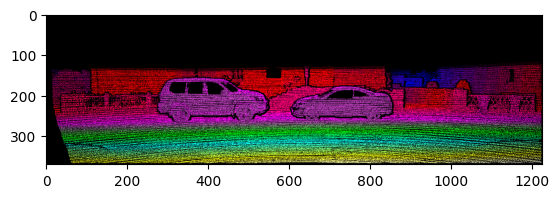

In [2]:
import matplotlib.pyplot as plt
from util import *

# load the data
leftI = load_image('data/000005_10_left_color.png')
rightI = load_image('data/000005_10_right_color.png')
dispI_gt = load_disp('data/000005_10_gt.png')
max_disp = np.max(dispI_gt)

plt.imshow(disp_to_color(dispI_gt, max_disp))
plt.show()

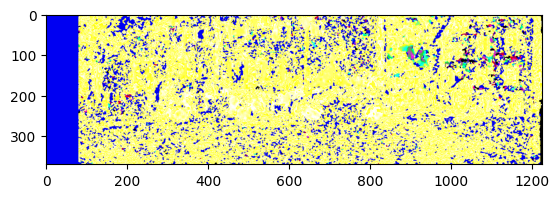

In [7]:
import cv2

NUM_DISP = 80
WINDOW_SIZE = 7

# use OPenCV's StereoSGBM method to compute disparity estimation dispI_est
# between the left image and the right image
# do not forget to divide the result by 16

stereo_sgbm = cv2.StereoSGBM_create(0, numDisparities=NUM_DISP, blockSize=WINDOW_SIZE)

dispI_est = stereo_sgbm.compute(leftI, rightI)


plt.imshow(disp_to_color(dispI_est, max_disp))
plt.show()

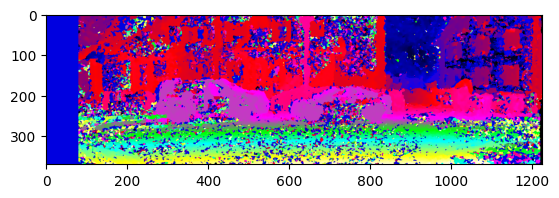

In [22]:
import cv2

NUM_DISP = 80
WINDOW_SIZE = 7

# use OPenCV's StereoSGBM method to compute disparity estimation dispI_est
# between the left image and the right image
# do not forget to divide the result by 16

stereo_sgbm = cv2.StereoSGBM_create(0, NUM_DISP, WINDOW_SIZE)

dispI_est = stereo_sgbm.compute(leftI, rightI) / 16


plt.imshow(disp_to_color(dispI_est, max_disp))
plt.show()

In [23]:
type(dispI_est)

numpy.ndarray

In [25]:
dispI_est.shape, dispI_gt.shape

((370, 1226), (370, 1226))

In [44]:
### KITTI parameters ###
f = 718.86
cx = 607.19
cy = 185.22
B = 0.537

# triangulate 3D Points
all_colors = cv2.cvtColor(leftI, cv2.COLOR_BGR2RGB)
height, width = leftI.shape[:2]

def triangulate(dispI, fn):
    points = []
    colors = []

    # compute the 3D points for the given disparity image and their corresponding colors
    # by implementing triangulation (back-projection)
    
    P = np.zeros((3, 4))
    
    P[0, 0] = f
    P[1, 1] = f
    P[0, 2] = -cx
    P[1, 2] = -cy
    P[2, 2] = 1
    P[0, 3] = -f * B
    P[1, 3] = -f * B

    
    c = disp_to_color(dispI)
    for i in range(dispI.shape[0]):
        for j in range(dispI.shape[1]):
            points.append(P.dot(np.array([i, j, dispI[i, j], 1]).T))
            colors.append(c[i, j])
    
    

    points = np.array(points)
    colors = np.array(colors)
    write2ply(points, colors, fn)
    
triangulate(dispI_gt, 'out/pts_gt.ply')
triangulate(dispI_est, 'out/pts_est.ply')

print('done!')

done!


Visualize the 3D point clouds using MeshLab or Open3D. Note that you might have to rotate the point cloud a little bit until you can make sense of it, especially with the estimated disparity map where there are outliers.

**Bonus**: Implement the outlier ratio metric of the KITTI to evaluate the estimation quantitatively.